# pytorch实现自动求导autograd
torch.autograd就是为方便用户使用，而专门开发的一套自动求导引擎，它能够根据输入和前向传播过程自动构建计算图，并执行反向传播

计算图(Computation Graph)是现代深度学习框架如PyTorch和TensorFlow等的核心，其为高效自动求导算法——反向传播(Back Propogation)提供了理论支持，了解计算图在实际写程序过程中会有极大的帮助。计算图的相关内容在吴恩达深度学习课程和邱希鹏《神经网络与深度学习》中，均有讲到，可以看我之前的[博客](https://xiuzhedorothy.gitee.io/2020/01/19/qian-kui-shen-jing-wang-luo-xiao-jie/ "博客")😀
![](https://s2.ax1x.com/2020/01/19/1CNLo6.png)
## 写在前面
不知道是因为这一章的东西比较硬核还是怎么的，学的时候半懂不懂的，不过学完之后总结到了方法：这一块不懂可以接着往下看，因为后面还会着重再讲这些东西，比如variable.backward()的三个参数，看半天看不懂，但后面会慢慢逐个说明👨‍🎓
## requires_grad
autograd中的核心数据结构是Variable。从v0.4版本起，Variable和Tensor合并。可以认为**需要求导的tensor**(requires_grad)即Variable。

Variable提供了大部分tensor支持的函数，但不支持部分inplace函数，因为它们会修改tensor自身，而在反向传播中，variable需要缓存原来的tensor来计算反向传播梯度。计算各个Variable的梯度，调用它们根节点Variable的`backward`方法即可，autograd会自动沿着计算图反向传播，计算每一个叶子节点的梯度(下来会举例解释)

In [1]:
#pre
import torch as t

`variable.backward(gradient=None, retain_graph=None, create_graph=None)`的参数解释：

- gradient：有关gradient的介绍见后面（书上的好像不太对，反正看不懂）
- retain_graph：反向传播需要缓存一些中间结果，反向传播之后，这些缓存就被清空，可通过指定这个参数不清空缓存，用来多次反向传播。
- create_graph：构建计算图

In [2]:
a=t.randn(3,4,requires_grad=True)
'''
其他形式：
    a=t.randn(3,4).requires_grad_()

    a=t.randn(3,4)
    a.requires_grad=True
'''
print(a)
b=t.zeros(3,4).requires_grad_()
print(b)

tensor([[ 1.6719e-01, -6.9152e-01, -1.9536e+00, -1.8011e-02],
        [-1.6282e+00, -1.1404e-03, -1.2241e+00, -1.1264e+00],
        [-1.5771e+00,  1.5322e+00,  1.6548e+00, -1.5076e+00]],
       requires_grad=True)
tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]], requires_grad=True)


In [3]:
c=a+b
print(c)
d = c.sum()
print(d)
print(d.backward()) # 反向传播
print(d.requires_grad)

tensor([[ 1.6719e-01, -6.9152e-01, -1.9536e+00, -1.8011e-02],
        [-1.6282e+00, -1.1404e-03, -1.2241e+00, -1.1264e+00],
        [-1.5771e+00,  1.5322e+00,  1.6548e+00, -1.5076e+00]],
       grad_fn=<AddBackward0>)
tensor(-6.3735, grad_fn=<SumBackward0>)
None
True


In [4]:
print(a.grad) # 即对a求导

# 此处虽然没有指定c需要求导，但c依赖于a，而a需要求导，
# 因此c的requires_grad属性会自动设为True
print(a.requires_grad, b.requires_grad, c.requires_grad)

tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]])
True True True


In [5]:
# 由用户创建的variable属于叶子节点，对应的grad_fn是None
print(a.is_leaf, b.is_leaf, c.is_leaf)

# c.grad是None, 因c不是叶子节点，它的梯度是用来计算a的梯度
# 所以虽然c.requires_grad = True,但其梯度计算完之后即被释放
print(c.grad is None)

True True False
True


上面写了这么多，其实我一个都没看懂。。。😥，感觉讲的怪怪的，一会冒出来一个参数一会儿又冒出来一个参数，这个例子感觉举的也不好，于是从apachecn的pytorch文档又扒了一个例子再来试一遍。
    PyTorch中，所有神经网络的核心是`autograd`包，`autograd`包中的**核心类**是`torch.Tensor`，如果将生成的tensor的属性设置为`.requires_grad=True`，如下面的例子：
 ```python
a=t.randn(3,4,requires_grad=True)
```
那么它将会追踪对于该张量的所有操作,当完成计算后：
- `backward()`方法可以自动计算所有梯度
- 这个张量的所有梯度将会自动累加到`.grad`属性

要阻止一个张量被跟踪历史，可以调用` .detach()`方法将其与计算历史分离，并阻止它未来的计算记录被跟踪

为了防止跟踪历史记录（和使用内存），可以将代码块包装在 with torch.no_grad(): 中。在**评估模型**时特别有用，因为模型可能具有 requires_grad = True 的可训练的参数，但是评估过程并不需要计算梯度。

除了上文提到的`torch.Tensor`类，还有一个类：`Function`对autograd的实现非常重要

- 每个张量都有一个`.grad_fn`属性，该属性引用了创建`Tensor`自身的`Function`（除非这个张量是用户手动创建的，即这个张量的`grad_fn`是`None`）
- `Tensor`和`Function`互相连接生成了一个**无环图(acyclic graph)**

> 在图论中，如果一个有向图从任意顶点出发无法经过若干条边回到该点，则这个图是一个**有向无环图（DAG,directed acyclic graph）**

如果需要计算导数，可以在`Tensor`上调用`.backward()`。如果`Tensor`是一个标量（即它包含一个元素的数据），则不需要为`backward()`指定任何参数，但是如果它有更多的元素，则需要指定一个`gradient`参数，该参数是形状匹配的张量。

In [6]:
x=t.ones(2,2,requires_grad=True)
print(x)

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)


In [7]:
y=x+2
print(y)
print('\n',y.grad_fn)

tensor([[3., 3.],
        [3., 3.]], grad_fn=<AddBackward0>)



上面的结果可见y有`grad_fn`属性

In [8]:
z = y * y * 3
out = z.mean()
print(z, out)

tensor([[27., 27.],
        [27., 27.]], grad_fn=<MulBackward0>) tensor(27., grad_fn=<MeanBackward0>)


In [9]:
out.backward()
print(x.grad)

tensor([[4.5000, 4.5000],
        [4.5000, 4.5000]])


上面的计算过程的公式为：
$y=x+2$，
$z=3y^{2}$，
$out=\frac{1}{n}\sum_{i=1}^{n}z_{i}$

`x.grad`即导数$\frac{\partial(out)}{\partial x}$

$out=\frac{1}{4}\sum_{i}^{4}z_{i}$，$z_{i}=3(x_{i}+2)^{2}$，所以$z_{i}|_{x_{i}=1}=27$，因此有：

$\frac{\partial(out)}{\partial x_{i}}=\frac{3}{2}(x_{i}+2)$，代入得 $4.5$

---------
数学上，若有向量值函数 $$\vec{y}=f(\vec{x})$$，那么 $$\vec{y}$$ 相对于 $$\vec{x}$$的梯度是一个雅可比矩阵：

$$
J=\left(\begin{array}{ccc}
   \frac{\partial y_{1}}{\partial x_{1}} & \cdots & \frac{\partial y_{m}}{\partial x_{1}}\\
   \vdots & \ddots & \vdots\\
   \frac{\partial y_{1}}{\partial x_{n}} & \cdots & \frac{\partial y_{m}}{\partial x_{n}}
   \end{array}\right)
$$

通常来说，`torch.autograd` 是计算雅可比向量积的一个“引擎”。也就是说，给定任意向量 $$v=\left(\begin{array}{cccc} v_{1} & v_{2} & \cdots & v_{m}\end{array}\right)^{T}$$，计算乘积 $$v^{T}\cdot J$$。如果 $$v$$ 恰好是一个标量函数 $$l=g\left(\vec{y}\right)$$ 的导数，即 $$v=\left(\begin{array}{ccc}\frac{\partial l}{\partial y_{1}} & \cdots & \frac{\partial l}{\partial y_{m}}\end{array}\right)^{T}$$，那么根据链式法则，雅可比向量积应该是 $$l$$ 对 $$\vec{x}$$ 的导数：

$$
J^{T}\cdot v=\left(\begin{array}{ccc}
   \frac{\partial y_{1}}{\partial x_{1}} & \cdots & \frac{\partial y_{m}}{\partial x_{1}}\\
   \vdots & \ddots & \vdots\\
   \frac{\partial y_{1}}{\partial x_{n}} & \cdots & \frac{\partial y_{m}}{\partial x_{n}}
   \end{array}\right)\left(\begin{array}{c}
   \frac{\partial l}{\partial y_{1}}\\
   \vdots\\
   \frac{\partial l}{\partial y_{m}}
   \end{array}\right)=\left(\begin{array}{c}
   \frac{\partial l}{\partial x_{1}}\\
   \vdots\\
   \frac{\partial l}{\partial x_{n}}
   \end{array}\right)
$$

（注意：行向量的$$ v^{T}\cdot J$$也可以被视作列向量的$$J^{T}\cdot v$$)

雅可比向量积的这一特性使得将外部梯度输入到具有非标量输出的模型中变得非常方便。

-----
**再来看一个例子：**

计算下面这个函数的导函数：
$$
y = x^2\bullet e^x
$$
它的导函数是：
$$
{dy \over dx} = 2x\bullet e^x + x^2 \bullet e^x
$$

In [10]:
def f(x):
    y=x**2*t.exp(x)
    return y
x = t.randn(3,4, requires_grad = True)
y = f(x)
y

tensor([[4.8295e-02, 4.9038e-01, 1.4586e+00, 4.8821e-02],
        [2.2538e-02, 7.9433e-03, 1.1186e-02, 9.6326e-03],
        [4.0448e+01, 2.8294e-01, 1.5485e-01, 6.9728e-01]],
       grad_fn=<MulBackward0>)

In [11]:
y.backward(t.ones(y.size()))
print(x.grad)

tensor([[-0.3398,  2.3211,  5.0744,  0.5372],
        [-0.2542,  0.1940, -0.1888,  0.2153],
        [77.9019,  1.6014,  1.0845,  2.9677]])


## 计算图
PyTorch中`autograd`的底层采用了计算图，计算图是一种特殊的有向无环图（DAG），用于记录算子与变量之间的关系。一般用矩形表示算子，椭圆形表示变量。如表达式$ \textbf {z = wx + b}$可分解为$\textbf{y = wx}$和$\textbf{z = y + b}$，其计算图如图3-3所示，图中`MUL`，`ADD`都是算子，$\textbf{w}$，$\textbf{x}$，$\textbf{b}$即变量。

![](https://s2.ax1x.com/2020/01/31/11qx1I.png)

如上有向无环图中，$\textbf{X}$和$\textbf{b}$是叶子节点（leaf node），这些节点通常由用户自己创建，不依赖于其他变量。$\textbf{z}$称为根节点，是计算图的最终目标。利用链式法则很容易求得各个叶子节点的梯度。
$${\partial z \over \partial b} = 1,\space {\partial z \over \partial y} = 1\\
{\partial y \over \partial w }= x,{\partial y \over \partial x}= w\\
{\partial z \over \partial x}= {\partial z \over \partial y} {\partial y \over \partial x}=1 * w\\
{\partial z \over \partial w}= {\partial z \over \partial y} {\partial y \over \partial w}=1 * x\\
$$
而有了计算图，上述链式求导即可利用计算图的反向传播自动完成，如下图
![](https://s2.ax1x.com/2020/01/31/11LaDK.png)
代码细节：

In [12]:
x = t.ones(1)
b = t.rand(1, requires_grad = True)
w = t.rand(1, requires_grad = True)
y = w * x # 等价于y=w.mul(x)
z = y + b # 等价于z=y.add(b)
print(x.requires_grad, b.requires_grad, w.requires_grad)
print(y.requires_grad)
print(x.is_leaf, w.is_leaf, b.is_leaf)
print(y.is_leaf, z.is_leaf)

# grad_fn可以查看这个variable的反向传播函数，
# z是add函数的输出，所以它的反向传播函数是AddBackward
print('\n',z.grad_fn)

# next_functions保存grad_fn的输入，是一个tuple，tuple的元素也是Function
# 第一个是y，它是乘法(mul)的输出，所以对应的反向传播函数y.grad_fn是MulBackward
# 第二个是b，它是叶子节点，由用户创建
print('\n','输出一个元组：',z.grad_fn.next_functions)

False True True
True
True True True
False False


 输出一个元组： ((<MulBackward0 object at 0x000001E2ECA638D0>, 0), (<AccumulateGrad object at 0x000001E2ECA63978>, 0))


In [13]:
# variable的grad_fn对应着和图中的function相对应
print(z.grad_fn.next_functions[0][0] == y.grad_fn,'\n')

# 注意元组的输出各种输出↓
for i in range(2):
    for ii in range(2):
        print('[',i,ii,']',z.grad_fn.next_functions[i][ii])

True 

[ 0 0 ] <MulBackward0 object at 0x000001E2ECA64438>
[ 0 1 ] 0
[ 1 0 ] <AccumulateGrad object at 0x000001E2ECA645C0>
[ 1 1 ] 0


In [14]:
# 第一个是w，叶子节点，需要求导，梯度是累加的
# 第二个是x，叶子节点，不需要求导，所以为None
y.grad_fn.next_functions

((<AccumulateGrad at 0x1e2eca49b70>, 0), (None, 0))

In [15]:
# 叶子节点的grad_fn是None
w.grad_fn,x.grad_fn

(None, None)

计算w的梯度的时候，需要用到x的数值(${\partial y\over \partial w} = x $)，这些数值在前向过程中会保存成buffer，在计算完梯度之后会自动清空。为了能够多次反向传播需要指定`retain_graph`来保留这些buffer

In [16]:
# 使用retain_graph来保存buffer
for i in range(5):
    z.backward(retain_graph=True)
    print(w.grad)
# 多次反向传播，梯度累加，这也就是w中AccumulateGrad标识的含义

tensor([1.])
tensor([2.])
tensor([3.])
tensor([4.])
tensor([5.])


In [17]:
def f(x):
    result = 1
    for ii in x:
        if ii.item()>0: 
            result=ii*result
    return result
x = t.arange(-2,4,dtype=t.float32).requires_grad_()
y = f(x) # y = x[3]*x[4]*x[5]
y.backward()
x.grad

tensor([0., 0., 0., 6., 3., 2.])

In [18]:
print(x)

tensor([-2., -1.,  0.,  1.,  2.,  3.], requires_grad=True)


有些时候我们可能不希望autograd对tensor求导。认为求导需要缓存许多中间结构，增加额外的内存/显存开销，那么我们可以关闭自动求导。对于不需要反向传播的情景（如inference，即测试推理时），关闭自动求导可实现一定程度的速度提升，并节省约一半显存，因其不需要分配空间计算梯度。**下面便是一个利用with函数关闭自动求梯度的代码：**

In [19]:
with t.no_grad():
    x = t.ones(1)
    w = t.rand(1, requires_grad = True)
    y = x * w
# y依赖于w和x，虽然w.requires_grad = True，但是y的requires_grad依旧为False
x.requires_grad, w.requires_grad, y.requires_grad

(False, True, False)

In [20]:
# 恢复默认配置
t.set_grad_enabled(True)

如果想要修改tensor的数值，但是又不希望被autograd记录，那么可以对tensor.data进行操作

In [21]:
a = t.ones(3,4,requires_grad=True)
b = t.ones(3,4,requires_grad=True)
c = a * b

print(a.data) # 还是一个tensor
print(a.data.requires_grad) # 但是已经是独立于计算图之外

d = a.data.sigmoid_() # sigmoid_ 是个inplace操作，会修改a自身的值
print('是否自动计算梯度：',d.requires_grad,'\n')
print(a)

tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]])
False
是否自动计算梯度： False 

tensor([[0.7311, 0.7311, 0.7311, 0.7311],
        [0.7311, 0.7311, 0.7311, 0.7311],
        [0.7311, 0.7311, 0.7311, 0.7311]], requires_grad=True)


如果我们希望对tensor进行操作，但是又不希望被记录, 可以使用tensor.data 或者tensor.detach()

In [22]:
# 近似于 tensor=a.data, 但是如果tensor被修改，backward可能会报错
tensor = a.detach()
tensor.requires_grad

False

In [23]:
# 统计tensor的一些指标，不希望被记录
mean = tensor.mean()
std = tensor.std()
maximum = tensor.max()

In [24]:
tensor[0]=1
# 下面会报错：　RuntimeError: one of the variables needed for gradient
#             computation has been modified by an inplace operation
#　因为 c=a*b, b的梯度取决于a，现在修改了tensor，其实也就是修改了a，梯度不再准确
# c.sum().backward() 

在反向传播过程中非叶子节点的导数计算完之后即被清空。若想查看这些变量的梯度，有两种方法：
- 使用autograd.grad函数
- 使用hook

`autograd.grad`和`hook`方法都是很强大的工具，更详细的用法参考官方api文档，这里举例说明基础的使用。推荐使用`hook`方法，但是在实际使用中应尽量避免修改grad的值。

**代码略（以后要用的时候再看，现在只看不用等于白学）**

>最后再来看看variable中grad属性和backward函数`grad_variables`参数的含义，这里直接下结论：
- variable $\textbf{x}$的梯度是目标函数${f(x)} $对$\textbf{x}$的梯度，$\frac{df(x)}{dx} = (\frac {df(x)}{dx_0},\frac {df(x)}{dx_1},...,\frac {df(x)}{dx_N})$，形状和$\textbf{x}$一致。
- 对于y.backward(grad_variables)中的grad_variables相当于链式求导法则中的$\frac{\partial z}{\partial x} = \frac{\partial z}{\partial y} \frac{\partial y}{\partial x}$中的$\frac{\partial z}{\partial y}$。z是目标函数，一般是一个标量，故而$\frac{\partial z}{\partial y}$的形状与variable $\textbf{y}$的形状一致。`z.backward()`在一定程度上等价于y.backward(grad_y)。`z.backward()`省略了grad_variables参数，是因为$z$是一个标量，而$\frac{\partial z}{\partial z} = 1$

以上是《深度学习框架PyTorch：入门与实践》中关于`grad_variables`参数 的介绍，但在我目前用的版本(1.2)，`grad_variables`被替换成了`gradient`参数。
> 如果需要计算导数，可以在Tensor上调用.backward()。如果Tensor是一个标量（即它包含一个元素的数据），则不需要为backward()指定任何参数，但是如果它有更多的元素，则需要指定一个gradient参数，该参数是形状匹配的张量。(来自apachecn pytorch快速入门)

<font color=red>pytorch 1.0中文文档：</font>
- gradient (*Tensor 或 None*) – 关于张量的梯度。如果它是一个张量，它将被自动转换成不要求梯度的张量，除非`create_graph`是`True`。标量张量或不需要梯度的可用`None`指定。如果None对所有grad_tensors可接受，则此参数可选。

<font color=red>在PyTorch中计算图的特点可总结如下：</font>

- autograd根据用户对variable的操作构建其计算图。对变量的操作抽象为`Function`。
- 对于那些不是任何函数(Function)的输出，由用户创建的节点称为叶子节点，叶子节点的`grad_fn`为None。叶子节点中需要求导的variable，具有`AccumulateGrad`标识，因其梯度是累加的。
- variable默认是不需要求导的，即`requires_grad`属性默认为False，如果某一个节点requires_grad被设置为True，那么所有依赖它的节点`requires_grad`都为True。
- variable的`volatile`属性默认为False，如果某一个variable的`volatile`属性被设为True，那么所有依赖它的节点`volatile`属性都为True。volatile属性为True的节点不会求导，volatile的优先级比`requires_grad`高。
- **多次反向传播时，梯度是累加的**。反向传播的中间缓存会被清空，为进行多次反向传播需指定`retain_graph`=True来保存这些缓存。
- 非叶子节点的梯度计算完之后即被清空，可以使用`autograd.grad`或`hook`技术获取非叶子节点的值。
- variable的grad与data形状一致，应避免直接修改variable.data，因为对data的直接操作无法利用autograd进行反向传播
- 反向传播函数`backward`的参数`grad_variables`可以看成链式求导的中间结果，如果是标量，可以省略，默认为1
- PyTorch采用动态图设计，可以很方便地查看中间层的输出，动态的设计计算图结构。

这些知识不懂大多数情况下也不会影响对pytorch的使用，但是掌握这些知识有助于更好的理解pytorch，并有效的避开很多陷阱

## 扩展autograd（暂略）

## 用autograd实现线性回归

In [25]:
import torch as t
%matplotlib inline
from matplotlib import pyplot as plt
from IPython import display 
import numpy as np

In [26]:
def get_fake_data(batch_size=8):
    ''' 产生随机数据：y = x*2 + 3，加上了一些噪声'''
    x = t.rand(batch_size,1) * 5
    y = x * 2 + 3 + t.randn(batch_size, 1)
    return x, y

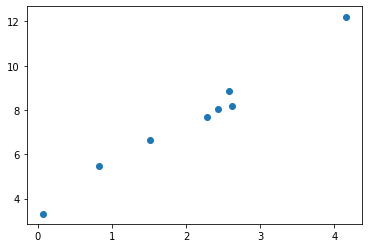

In [27]:
x, y = get_fake_data()
plt.scatter(x.squeeze().numpy(), y.squeeze().numpy())

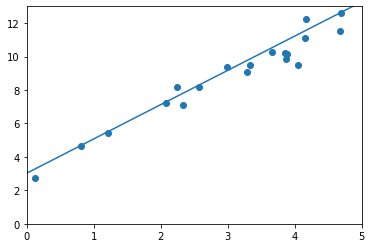

2.169923782348633 3.0968210697174072


In [28]:
# 随机初始化参数
w=t.rand(1,1,requires_grad=True)
b=t.rand(1,1,requires_grad=True)
losses=np.zeros(500)

lr=0.005

for ii in range(500):
    x,y=get_fake_data(batch_size=32)
    
    #forward: calculate
    y_pred=x.mm(w)+b.expand_as(y)
    loss=0.5*(y_pred-y)**2
    loss=loss.sum()
    losses[ii]=loss.item() #Returns the value of this tensor as a standard Python number. This only works
    
    loss.backward()
    
    # 更新梯度
    w.data.sub_(lr*w.grad.data) #参数学习不需要用来记录然后求梯度，故直接修改data
    b.data.sub_(lr*b.grad.data)
    # 梯度清零
    w.grad.data.zero_()
    b.grad.data.zero_()
    
    if ii%50 ==0:
        # 画图
        display.clear_output(wait=True)
        x = t.arange(0, 6).view(-1, 1).float()
        y = x.mm(w.data) + b.data.expand_as(x)
        plt.plot(x.numpy(), y.numpy()) # predicted
        
        x2, y2 = get_fake_data(batch_size=20) 
        plt.scatter(x2.numpy(), y2.numpy()) # true data
        
        plt.xlim(0,5)
        plt.ylim(0,13)   
        plt.show()
        plt.pause(0.5)
        
print(w.item(), b.item())

(5, 50)

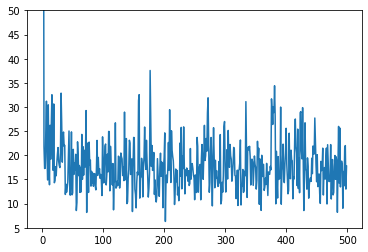

In [29]:
plt.plot(losses)
plt.ylim(5,50)

用autograd实现的线性回归最大的不同点就在于autograd不需要计算反向传播，可以自动计算微分。这点不单是在深度学习，在许多机器学习的问题中都很有用。另外需要注意的是在每次反向传播之前要记得先把梯度清零。

本章主要介绍了PyTorch中两个基础底层的数据结构：Tensor和autograd中的Variable。Tensor是一个类似Numpy数组的高效多维数值运算数据结构，有着和Numpy相类似的接口，并提供简单易用的GPU加速。Variable是autograd封装了Tensor并提供自动求导技术的，具有和Tensor几乎一样的接口。`autograd`是PyTorch的自动微分引擎，采用动态计算图技术，能够快速高效的计算导数。